In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import json

Valassis Digital has run a digital advertising campaign for one of our clients. We ran two creatives during the campaign, one old and one new. Users in a "test" group received the new ad during the campaign. The goal of my analysis was to answer 2 questions. Did the new creative increase conversions? Would retargeting have improved performance for this campaign?


## Data Prep

In [2]:
bids=pd.read_csv('../bid_requests.csv')
bids.head()

,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


In [3]:
users=pd.read_csv('../user_attributes.csv')
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


In [4]:
columns=list(json.loads(users['attributes'][0]).keys())
users2=pd.DataFrame(np.asarray(list(users['attributes'].apply(lambda x: sorted(json.loads(x).items()))))[:,:,1],columns=columns)
users2['user_id']=users['user_id']
users2.head()

,age,gender,location,test,user_id
0,33,F,FL,1,00003e3b9e5336685200ae85d21b4f5e
1,26,M,AL,1,000053b1e684c9e7ea73727b2238ce18
2,29,F,AR,1,00029153d12ae1c9abe59c17ff2e0895
3,29,M,SC,0,0002ac0d783338cfeab0b2bdbd872cda
4,27,F,AR,1,0004d0b59e19461ff126e3a08a814c33


In [5]:
users2['test']=users2['test'].apply(lambda x: int(x))
users2['age']=users2['age'].apply(lambda x: float(x))

In [6]:
users2=users2.drop_duplicates().reset_index(drop=True)
bids=bids.drop_duplicates().reset_index(drop=True)
final=users2.merge(bids,on='user_id',how='left')
bids=bids.dropna().reset_index(drop=True)
users2=users2.dropna().reset_index(drop=True)
final=final.dropna().reset_index(drop=True)
final.head()

,age,gender,location,test,user_id,timestamp,bid,win,conversion
0,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-01 13:43:34,1.0,0.0,0.0
1,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-04 03:59:18,0.0,0.0,0.0
2,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-04 17:41:50,1.0,1.0,0.0
3,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-07 04:02:42,1.0,1.0,0.0
4,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-08 09:05:01,1.0,0.0,0.0


In [7]:
test=pd.DataFrame(users2[users2['test']==1])
control=pd.DataFrame(users2[users2['test']==0])

In [8]:
test2=pd.DataFrame(final[final['test']==1])
control2=pd.DataFrame(final[final['test']==0])

## User characteristics in the test and control

In [9]:
print('Number of Users:Test {},Control {}'.format(len(test), len(control)))

Number of Users:Test 56084,Control 43916


### Gender distributions in the test and control groups are about the same.

In [10]:
print('Gender in the test group')
test['gender'].value_counts()/len(test)*100

Gender in the test group


F    50.117681
M    49.882319
Name: gender, dtype: float64

In [11]:
print('Gender  in the control group')
control['gender'].value_counts()/len(control)*100

Gender  in the control group


M    50.325622
F    49.674378
Name: gender, dtype: float64

### Location distributions in the test and control groups are different, which could affect results.

Text(0.5, 1.0, 'Location in the test group')

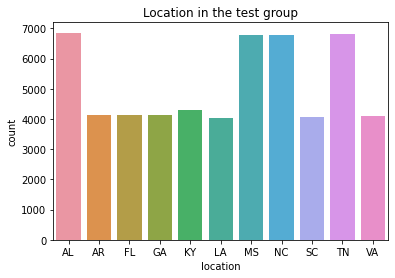

In [12]:
sns.countplot(test['location'].sort_values())
plt.title('Location in the test group')

Text(0.5, 1.0, 'Location in the control group')

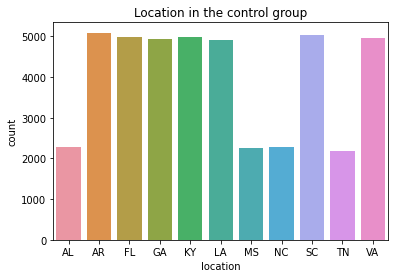

In [13]:
sns.countplot(control['location'].sort_values())
plt.title('Location in the control group')

### Age distributions in the test and control groups are about the same.

In [14]:
print('Age in the test and control groups')
print('Median: Test {},Control {}'.format(np.median(test['age']), np.median(control['age'])))
print('Mean: Test {},Control {}'.format(np.mean(test['age']), np.mean(control['age'])))
print('Standard Deviation: Test {},Control {}'.format(np.std(test['age']),np.std(control['age'])))

Age in the test and control groups
Median: Test 25.0,Control 25.0
Mean: Test 25.493830682547607,Control 25.488364149740413
Standard Deviation: Test 4.6043110471866955,Control 4.599852715678207


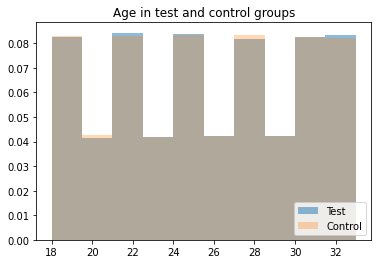

In [15]:
plt.hist(test['age'], density=True,label = "Test", alpha = .5)
plt.hist(control['age'],density=True,label = 'Control', alpha = .3)
plt.title('Age in test and control groups')
plt.legend(loc ='lower right')

## Experiment results

- The percentage of bids tells us the percentage of user requests we bid on.
- The percentage of wins tells us how many ads we were able to serve, out of all of the bids we made.
- The conversion rate tells us how many accepted offers there were, out of all of the times the ad was served.

In [16]:
print("Percentage of Bids")
print('Test {},Control {}'.format(np.mean(test2['bid'])*100,np.mean(control2['bid'])*100))

Percentage of Bids
Test 49.97025685646047,Control 49.977680870789406


In [17]:
#only look at wins for bids
bidtest=test2[test2['bid']==1]
bidcontrol=control2[control2['bid']==1]

print("Percentage of Bids Won")
print('Test {},Control {}'.format(np.mean(bidtest['win'])*100,np.mean(bidcontrol['win'])*100))

Percentage of Bids Won
Test 50.101867974367174,Control 50.05076529638536


### Conversion rates were different in different states. 

In [18]:
#only look at conversions for wins in each group
wintest=test2[test2['win']==1]
wincontrol=control2[control2['win']==1]

Text(0.5, 1.0, 'Conversion rates by location in the test group')

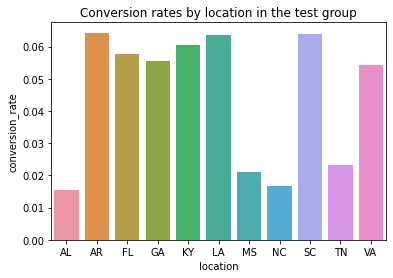

In [19]:
locs=pd.DataFrame(wintest.groupby(['location'])[['win','conversion']].sum()).reset_index()
locs['conversion_rate']=locs['conversion']/locs['win']
locs=locs.sort_values(['location'])
locs2=pd.DataFrame(wincontrol.groupby(['location'])[['win','conversion']].sum()).reset_index()
locs2['conversion_rate']=locs2['conversion']/locs2['win']
locs2=locs2.sort_values(['location'])

sns.barplot(locs['location'],locs['conversion_rate'])
plt.title('Conversion rates by location in the test group')

Text(0.5, 1.0, 'Conversion rates by location in the control group')

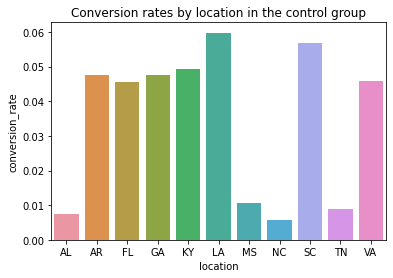

In [20]:
sns.barplot(locs2['location'],locs2['conversion_rate'])
plt.title('Conversion rates by location in the control group')

### The test group contained states with lower conversion rates. It's overall conversion rate may have been lowered because of this.

### The overall conversion rate was slightly higher in the control group.

In [21]:
print("Overall Conversion rate")
print('Test {},Control {}'.format(np.mean(wintest['conversion'])*100,np.mean(wincontrol['conversion'])*100))

Overall Conversion rate
Test 4.009693244281578,Control 4.153193825880056


### I'll need to break out results by state, but first I'll look at the conversions distributions.

In [22]:
def plot_sample_means(test,control):
    
    tests=[]
    controls=[]


    for i in range(10000):
        tes = np.random.choice(test,50, replace=True).mean()
        con = np.random.choice(control, 50, replace=True).mean()

        controls.append(con)
        tests.append(tes)

    plt.hist(controls, alpha=0.5, density=True,label='Control') 
    plt.hist(tests, alpha=0.3, density=True,label='Test') 
    plt.xticks(rotation=85)
    plt.legend(loc='upper right')
    plt.title('Sample Means: Conversions')
    plt.show()

    return (tests,controls)

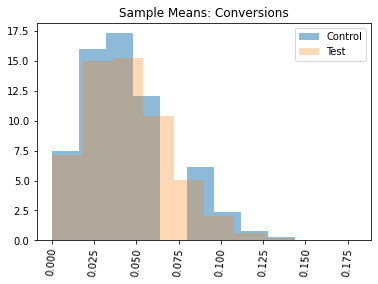

In [23]:
tests,controls=plot_sample_means(wintest['conversion'],wincontrol['conversion'])

###  The sampled distribution of sample means for the conversion rates seem skewed. I'll check for normality using a Q-Q plot and this will tell me if I need to use Mann Whitney U instead of TTest for my probability test.

### Q-Q Plots

In [24]:
rand1=np.random.normal(1, .5, 100)
rand1.sort()
#tests and controls
wtest=np.random.choice(tests,100)
wcontrol=np.random.choice(controls,100)
wtest.sort()
wcontrol.sort()

### If the sample distribution of sample means for conversions was normal then these plots would form a diagonal line.

Text(0.5, 1.0, 'Test sample means vs normal distribution')

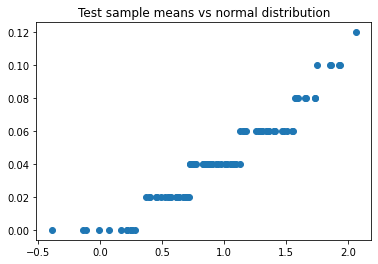

In [25]:
plt.plot(rand1,wtest,'o')
plt.title('Test sample means vs normal distribution')

Text(0.5, 1.0, 'Control sample means vs normal distribution')

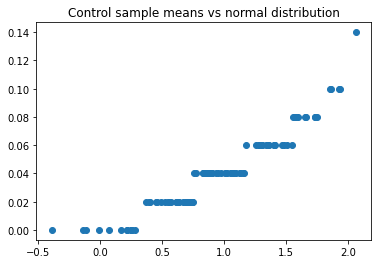

In [26]:
plt.plot(rand1,wcontrol,'o')
plt.title('Control sample means vs normal distribution')

## Break out results by state

GA


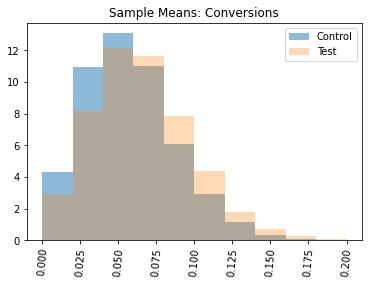

Ttest_indResult(statistic=2.0832290115145393, pvalue=0.037249302887066814)
MannwhitneyuResult(statistic=22092633.0, pvalue=0.018627295552976892)
Conversion rates: Test 5.567964262922782, Control 4.770616380523501
                              
SC


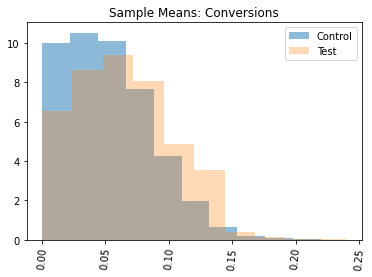

Ttest_indResult(statistic=1.7432931972534298, pvalue=0.08130466084238078)
MannwhitneyuResult(statistic=23371592.0, pvalue=0.04065289281041387)
Conversion rates: Test 6.403537504094333, Control 5.69390402075227
                              
AR


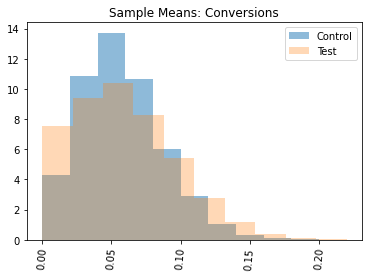

Ttest_indResult(statistic=4.318549755499415, pvalue=1.5815844510087268e-05)
MannwhitneyuResult(statistic=22975966.0, pvalue=7.952179695390996e-06)
Conversion rates: Test 6.431129925105829, Control 4.743758212877792
                              
AL


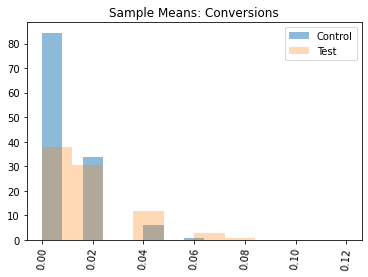

Ttest_indResult(statistic=3.526831457619122, pvalue=0.000421936849052911)
MannwhitneyuResult(statistic=17698160.0, pvalue=0.0002114613080136907)
Conversion rates: Test 1.5419147067434371, Control 0.7466973004020678
                              
KY


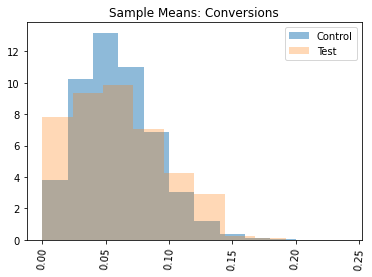

Ttest_indResult(statistic=2.881133079539736, pvalue=0.003968564841668542)
MannwhitneyuResult(statistic=23582682.0, pvalue=0.0019860508539496276)
Conversion rates: Test 6.050156739811912, Control 4.935794542536116
                              
VA


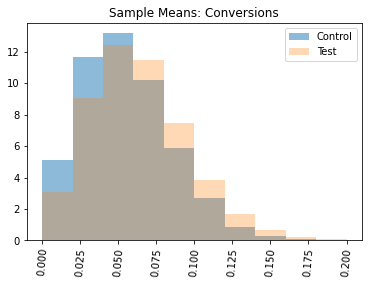

Ttest_indResult(statistic=2.2512467114447356, pvalue=0.024385876822207483)
MannwhitneyuResult(statistic=22532798.0, pvalue=0.012195844213941187)
Conversion rates: Test 5.415575916230367, Control 4.57235072619688
                              
NC


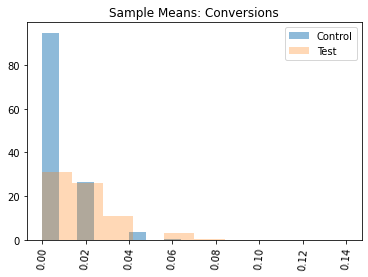

Ttest_indResult(statistic=4.9077951156648965, pvalue=9.315397535763049e-07)
MannwhitneyuResult(statistic=18108504.0, pvalue=4.7024345583483185e-07)
Conversion rates: Test 1.680101000291347, Control 0.562271577171774
                              
LA


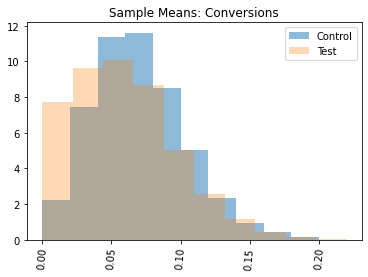

Ttest_indResult(statistic=0.9251568724005208, pvalue=0.354900872317904)
MannwhitneyuResult(statistic=22497934.0, pvalue=0.17744225753863713)
Conversion rates: Test 6.362757731958762, Control 5.978559648158329
                              
TN


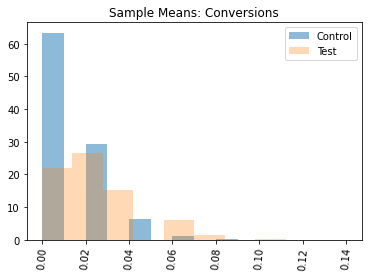

Ttest_indResult(statistic=5.110118087927024, pvalue=3.262804646832205e-07)
MannwhitneyuResult(statistic=16722699.5, pvalue=1.650123241617015e-07)
Conversion rates: Test 2.3335555767215923, Control 0.8972772277227722
                              
MS


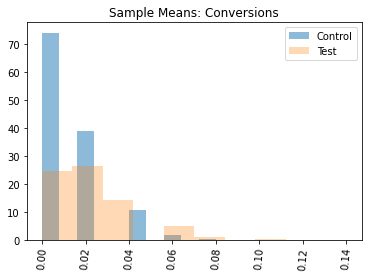

Ttest_indResult(statistic=3.9686061830916013, pvalue=7.26637615460172e-05)
MannwhitneyuResult(statistic=17544725.5, pvalue=3.647466055747221e-05)
Conversion rates: Test 2.110533032296064, Control 1.062912956047113
                              
FL


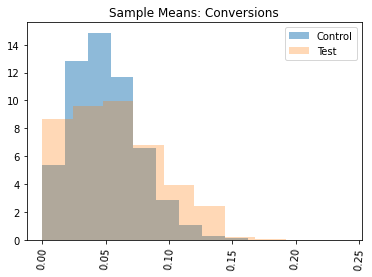

Ttest_indResult(statistic=3.139721307364933, pvalue=0.0016947748670345382)
MannwhitneyuResult(statistic=21864641.0, pvalue=0.0008485707450219889)
Conversion rates: Test 5.757033664010408, Control 4.556821339260906
                              


In [27]:
for loc in list(set(wintest['location'])):
    print(loc)
    test=pd.DataFrame(wintest[wintest['location']==loc])['conversion']
    control=pd.DataFrame(wincontrol[wincontrol['location']==loc])['conversion']
    tests,controls=plot_sample_means(test, control)
    print(ttest_ind(test, control))
    print(mannwhitneyu(test, control))       
    print('Conversion rates: Test {}, Control {}'.format(np.mean(test)*100,np.mean(control)*100))
    print("                              ")

### The p value for the LA state Mann Whitney U test is too high, so results for LA are not conclusive, but for the other states the null hypothesis did not hold.  The new creative likely did affect conversion rates in these other states in the test group. In all of the states the conversion rate in the test group was higher.

## Would retargeting have helped in this campaign?

In [28]:
# Find out how many times a user has been served & how many times a converted user has been served

bids=bids.sort_values(['user_id','timestamp']).reset_index(drop=True)

save='goo'
times=[]
timesafter=[]
for i,j,k in zip(bids['user_id'],bids['win'],bids['conversion']):
    if save!=i:
        count=0
        count2=0
        countcon=0
    if j==1:
        count+=1
    if (j==1 and countcon==1):
        count2+=1
    if k==1:
        countcon=1
    times.append(count)
    timesafter.append(count2)
    save=i
bids['times_served']=times
bids['served_to_converted']=timesafter

In [29]:
bids.head()

,timestamp,user_id,bid,win,conversion,times_served,served_to_converted
0,2017-01-01 13:43:34,00003e3b9e5336685200ae85d21b4f5e,1,0,0,0,0
1,2017-01-04 03:59:18,00003e3b9e5336685200ae85d21b4f5e,0,0,0,0,0
2,2017-01-04 17:41:50,00003e3b9e5336685200ae85d21b4f5e,1,1,0,1,0
3,2017-01-07 04:02:42,00003e3b9e5336685200ae85d21b4f5e,1,1,0,2,0
4,2017-01-08 09:05:01,00003e3b9e5336685200ae85d21b4f5e,1,0,0,2,0


In [30]:
# Look only at the activity of the previously converted 
bidscon=pd.DataFrame(bids[bids['served_to_converted']>0])
# Look only at wins for the previously converted
bidsconwin=pd.DataFrame(bidscon[bidscon['win']==1])
"Conversion rate for converted {}".format(np.mean(bidsconwin['conversion'])*100)

'Conversion rate for converted 5.876229034123771'

In [31]:
# Look only at wins for the unconverted
bidsnot=pd.DataFrame(bids[bids['served_to_converted']==0])
bidswon=pd.DataFrame(bidsnot[bidsnot['win']==1])
"Conversion rate for unconverted {}".format(np.mean(bidswon['conversion'])*100)

'Conversion rate for unconverted 3.9621521545571463'

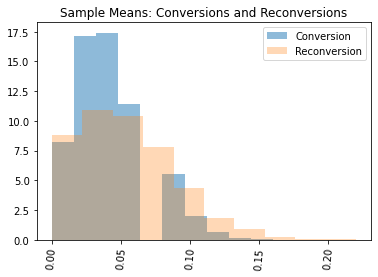

MannwhitneyuResult(statistic=599985966.5, pvalue=1.1534574793122919e-18)
Ttest_indResult(statistic=-8.743374442650786, pvalue=2.2851847817288605e-18)
                              


In [32]:
    tests=[]
    controls=[]


    for i in range(10000):
        tes = np.random.choice(bidswon['conversion'],50, replace=True).mean()
        con = np.random.choice(bidsconwin['conversion'], 50, replace=True).mean()
        
        tests.append(tes)
        controls.append(con)
        

    plt.hist(tests, alpha=0.5, density=True,label='Conversion') 
    plt.hist(controls, alpha=0.3, density=True,label='Reconversion') 
    plt.xticks(rotation=85)
    plt.legend(loc='upper right')
    plt.title('Sample Means: Conversions and Reconversions')
    plt.show()

    print(mannwhitneyu(bidswon['conversion'], bidsconwin['conversion']))
    print(ttest_ind(bidswon['conversion'], bidsconwin['conversion']))
    print("                              ")

### The p value for Mann Whitney U (and Ttest) is below 0.05 which means that the conversion rate amongst converted users really was higher than the conversion rate amongst the unconverted.

### Q tests show that both distributions are skewed

In [33]:
rand1=np.random.normal(1, .5, 100)
rand1.sort()
#tests and controls
wtest=np.random.choice(tests,100)
wcontrol=np.random.choice(controls,100)
wtest.sort()
wcontrol.sort()

Text(0.5, 1.0, 'Test sample means vs normal distribution')

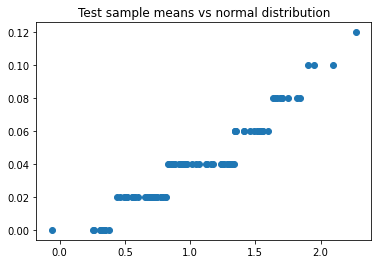

In [34]:
plt.plot(rand1,wtest,'o')
plt.title('Test sample means vs normal distribution')

Text(0.5, 1.0, 'Test sample means vs normal distribution')

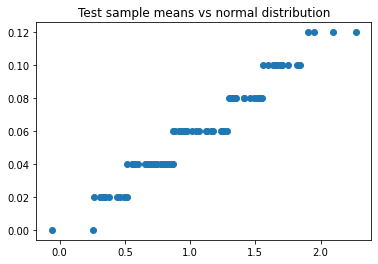

In [35]:
plt.plot(rand1,wcontrol,'o')
plt.title('Test sample means vs normal distribution')

Exercises / Questions
    1. What do the different distributions of requests by users tell us?
    
The distributions of user characteristics in the test and control groups were about the same except for user locations. The test group contained states with lower conversion rates.

When I broke out results by state, I found that the conversion rate for each state except for LA was higher in the test group than in the control group. Results for LA were not conclusive.

    2. Based on insights from #1, was the test effective?
Were test users more likely to convert than control users? Yes. I rejected the null hypothesis for all but the state of LA, and concluded that conversion rates for the states in the test group were higher than those of the same states in the control group. 

    3. Should we consider retargeting users that have previously converted?
Retargeting previously converted users in this particular campaign would have improved performance. The conversion rate in the converted users group was almost 2 points higher than the one in the  unconverted users group.